# 03 Parameter estimation

Spectral kernels are flexible but difficult to optimize, to solve this we equip the toolkit with different ways to initialize the parameters before training.

In this notebook we will showcase the diferent initialization for single output spectral mixture and multioutput kernels.

For single output spectral mixture kernel there is 3 ways:
* __Random__: Uses heuristic defined in ndrew Wilson PHD thesis, 
    - Inverse of lengthscales should be drawn from truncated Gaussian |N(0, max_dist^2)|
    - Draw means from Unif(0, 0.5 / minimum distance between two points)
    - Mixture weights should be roughly the std  of the y values divided by the number of mixtures
    - 
* __BNSE__: Uses Bayesian Nonparametric Spectral Estimation (Tobar 2018) to estimate the power spectral density (PSD) of the signal, and asign.
    - Find the peaks in the PSD and order it by magnitude
    - Means as the position of the first Q peaks
    - Lengthscales as the width of the peaks.
    - Mixture weight as the normalized peaks magnitude.
    

* __Lomb Scargle__: Uses Lomb Scargle periodogram and obtain an estimate of the PSD, then follow the same heuristic as BNSE.


For multiputput spectral kernels there is 2 ways:

* __SM__: Fit and independent GP with spectral mixture kernel for each channel, then use those parameters as initial parameters.

* __BNSE__: For each channel estimate the PSD using BNSE, and apply the same heuristics as the single output case.

In both cases the noise for each channel is initializated as $1/30$ of the channels variance.

In [1]:
import mogptk
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('notebook', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 4)

## Synthetic  Data

To showcase the initialization, we first create a dataset consisting in a sum of sinuoids

$$ y(t) = \sum_{i=1}^{3} a_i \sin(t \cdot f_i) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma_n^2) $$

With known frequencies $f_i$ and amplitudes $a_i$, when fiting the spectral mixture kernel, we should should expect the _means_ to have similar values as the frequencies and the _mixture weigths_ to be in proportion of the amplitudes.

First we create a numpy array with the function, then we erase half of the data in order to do predictions.

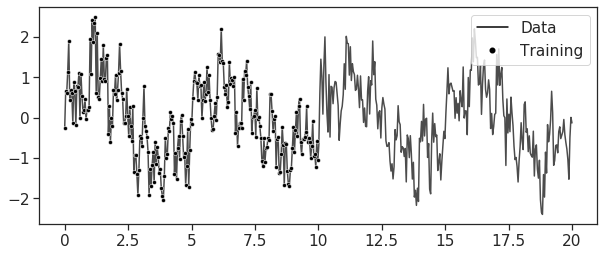

In [3]:
# target freq to estimate
target_freqs = np.array([0.2, 1, 2])
target_amps = [1, 0.5, 0.5]

n_points = 500

t = np.linspace(0, 20, n_points)
y = np.zeros(n_points)

for i in range(3):
    y += target_amps[i] * np.sin(2 * np.pi * target_freqs[i] * t)
    
y_n = y + np.random.normal(scale=0.4, size=n_points)

# data class
data = mogptk.Data(t.reshape(-1, 1), y_n)
data.remove_range(start=10.0, end=None)

x_pred = t

data.plot();

We show the spectrum and can the there is 3 peaks, each one in one of the frequencies

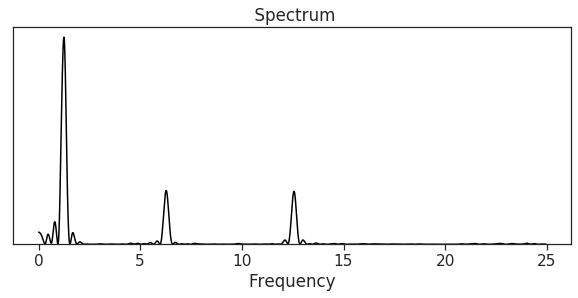

In [4]:
data.plot_spectrum()

## No initialization

Without initialization, the kernel parameters are sampled random from $(0, 1]$, the PSD given by the Fourier transform of the kernel, where in the case of spectral mixture kernel is the sum of Gaussians in the frequency space, this is done with the [`mogptk.SM.plot_psd`](https://games-uchile.github.io/MultiOutputGP-Toolkit/sm.html#mogptk.sm.SM.plot_psd)

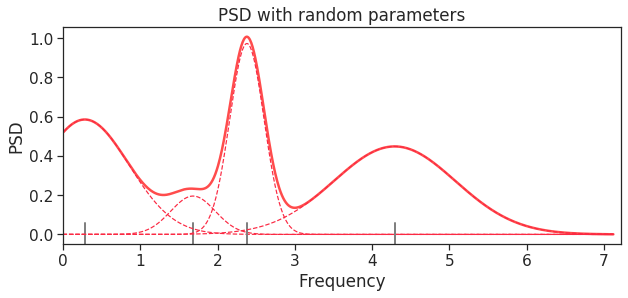

In [5]:
# create model
model = mogptk.SM([data], Q=4)

model.plot_psd(title='PSD with random parameters');

Now we can do predictions with the nontrained noninitialized model

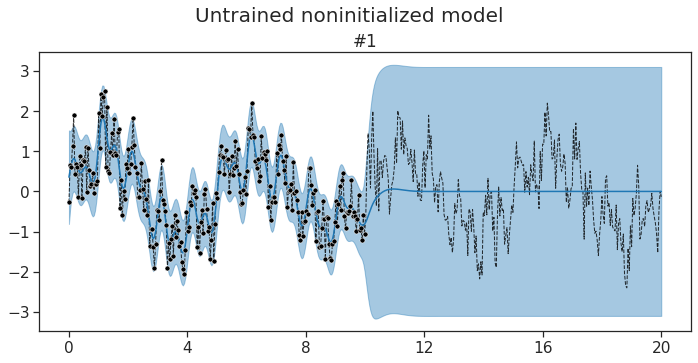

In [6]:
model.predict(x_pred)
model.plot_prediction(figsize=(10, 5), title='Untrained noninitialized model');

## Initialization

Other methods can be uncommented to obtain the result of different initializations, see [`mogptk.SM.estimate_parameters`](https://games-uchile.github.io/MultiOutputGP-Toolkit/sm.html#mogptk.sm.SM.estimate_parameters) for more info


**Note**: each method has is own `estimate_parameters` method, see the [documentation](https://games-uchile.github.io/MultiOutputGP-Toolkit/index.html) for particular details for each model.

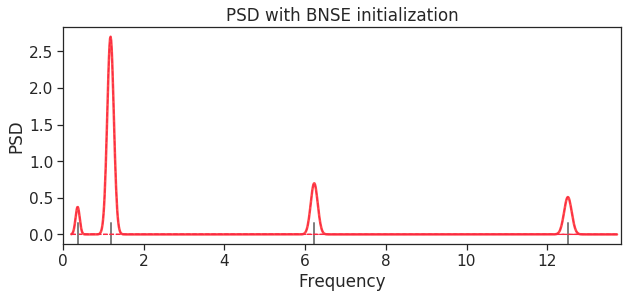

In [7]:
# initialize params
method = 'BNSE'
# method = 'LS'
# method = 'Random'

model.estimate_parameters(method=method)

model.plot_psd(title='PSD with {} initialization'.format(method));

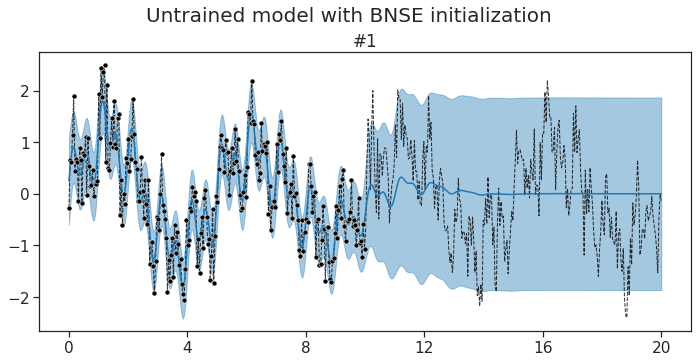

In [8]:
model.predict(x_pred)
model.plot_prediction(figsize=(10, 5), title='Untrained model with {} initialization'.format(method));

## Training

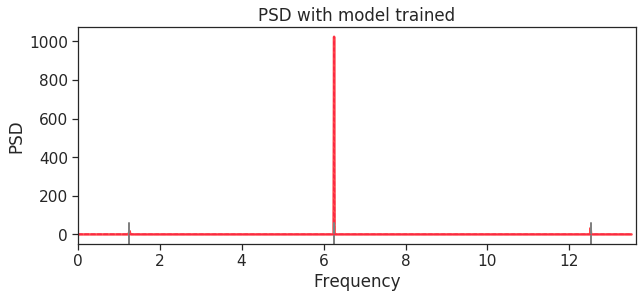

In [9]:
model.train(method='L-BFGS-B', maxiter=500, tol=1e-20)

model.plot_psd(title='PSD with model trained');

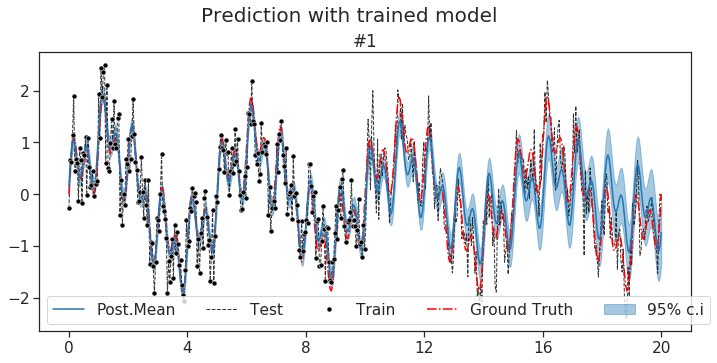

In [10]:
y_pred, lower_ci, upper_ci  = model.predict(x_pred)

fig, ax = model.plot_prediction(figsize=(10, 5), title='Prediction with trained model')
ax[0].plot(t, y, '-.r', label='Ground Truth')
ax[0].legend(ncol=5);

# Initialization for multioutput kernels

First we create a similar dataset as the used in the [00 - Quick Start](https://github.com/GAMES-UChile/MultiOutputGP-Toolkit/blob/master/examples/00_Quick_Start.ipynb) notebook.

In [11]:
n_points = 100
t = np.linspace(0, 6, n_points)

y1 = np.sin(6 * t)
y1 += np.random.normal(scale=0.1, size=len(t))

y2 = np.sin(6 * t + 2)
y2 += np.random.normal(scale=0.1, size=len(t))


y3 = np.sin(6 * t) - np.sin(4 * t)
y3 += np.random.normal(scale=0.1, size=len(t))


y4 = 4 * np.sin(6 * (t - 2))
y4 += np.random.normal(scale=0.1, size=len(t))

data1 = mogptk.Data(t, y1, name='A')
data2 = mogptk.Data(t, y2, name='B')
data3 = mogptk.Data(t, y3, name='C')
data4 = mogptk.Data(t, y4, name='D')

# create dataset
dataset = mogptk.DataSet(data1, data2, data3, data4)

for data in dataset:
    data.remove_randomly(pct=0.3)

# remove for channel 0
dataset[0].remove_range(start=2.0, end=None)

# create input for model prediction
x_pred = [t for i in dataset]

## Create model

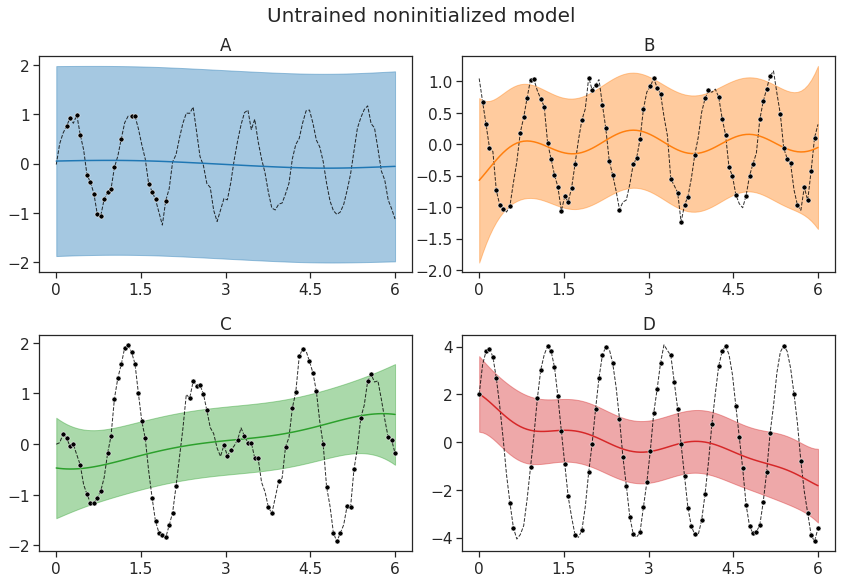

In [12]:
model = mogptk.MOSM(dataset, Q=2)

model.predict(x_pred)
model.plot_prediction(title='Untrained noninitialized model');

## Initialization

In [13]:
# method = 'BNSE'
method = 'SM'

model.estimate_parameters(method)

Optimization terminated successfully.
         Current function value: -12.786431
         Iterations: 90
         Function evaluations: 121
         Gradient evaluations: 121
         Current function value: -52.468732
         Iterations: 65
         Function evaluations: 149
         Gradient evaluations: 137
         Current function value: -38.586876
         Iterations: 37
         Function evaluations: 120
         Gradient evaluations: 109
         Current function value: -55.971074
         Iterations: 70
         Function evaluations: 150
         Gradient evaluations: 140


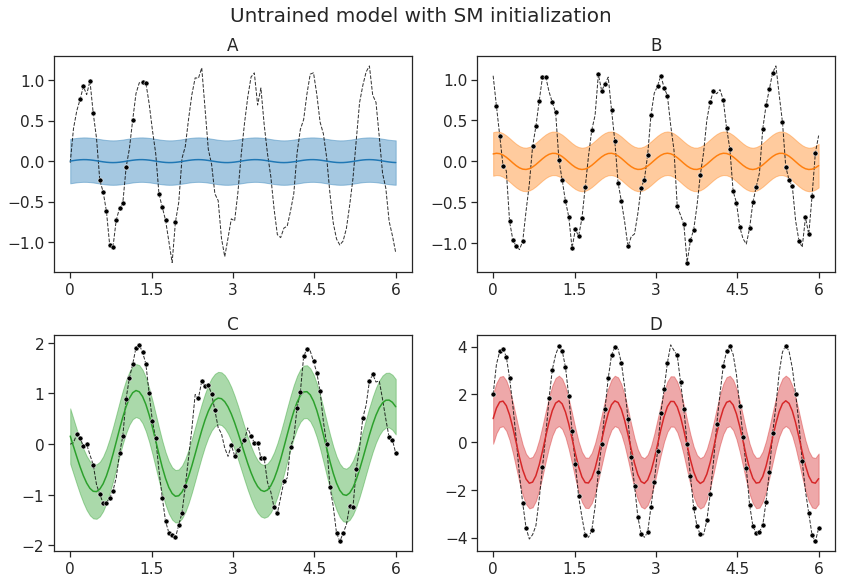

In [14]:
model.predict(x_pred)
model.plot_prediction(title='Untrained model with {} initialization'.format(method));

## Training

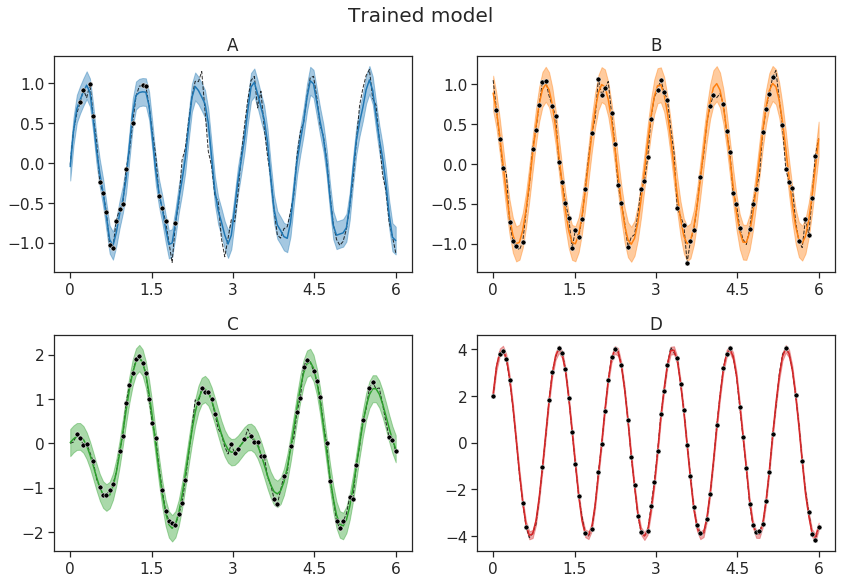

In [15]:
model.train(maxiter=200)

model.predict(x_pred)
model.plot_prediction(title='Trained model');